In [124]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#get all the files from your experiment
import glob

#deal with the .fcs file format
import fcsparser

#for writing info back to excel ID sheet
import openpyxl

## Use glob to get all the fcs files you want to deal with

In [125]:
dir_with_fcs_files_path = '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min'

#get all the .fcs files in the directory (doesn't walk down directories to aggregate all further along dir tree)
allfcs = glob.glob(dir_with_fcs_files_path + '/*.fcs')

In [126]:
allfcs[0:9]

['../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\bfp-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\bfpfinal-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\blank-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\blank10k-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\blankfinal-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\DI-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\preplateDI-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\RDM2018-10-23.0002.fcs']

In [127]:
#ugly nested list comprehension to get all the non control files

#using list comprehensionn to exclude files that have ctrl information in them
expfcs = [c for c in 
 [b for b in 
  [a for a in 
   [s for s in allfcs if 'bfp' not in s]
  if 'yfp' not in a]
 if 'DI' not in b]
if 'blank' not in c]

#nicer way to use previous list to get ctrls out of allfcs

ctrlfcs = [d for d in allfcs if d not in expfcs]

finalctrlfcs = [f for f in ctrlfcs if 'final' in f]

In [128]:
#I created a csv file that correlates fcs file number to well and volume flowed
ids_xlsx_path = '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min/fcs num to well ID.xlsx'

ids = pd.read_excel(ids_xlsx_path, dtype=str)

In [129]:
ids.head(11)

,fcs num,well,vol,file
0,0001,BAD,x,../Local Data/20181009 top 4 A B cell vars A=B...
1,0002,A1,x,../Local Data/20181009 top 4 A B cell vars A=B...
2,0003,B1,x,../Local Data/20181009 top 4 A B cell vars A=B...
3,0004,C1,x,../Local Data/20181009 top 4 A B cell vars A=B...
4,0005,D1,x,../Local Data/20181009 top 4 A B cell vars A=B...
5,0006,E1,x,../Local Data/20181009 top 4 A B cell vars A=B...
6,0007,BAD,x,../Local Data/20181009 top 4 A B cell vars A=B...
7,0008,F1,35,../Local Data/20181009 top 4 A B cell vars A=B...
8,0009,G1,35,../Local Data/20181009 top 4 A B cell vars A=B...
9,0010,H1,35,../Local Data/20181009 top 4 A B cell vars A=B...


In [130]:
def write_file_assoc_to_xlsx (ids_frame_w_fnames, ids_xlsx_path):

    #the check to see if the ids xlsx file already has filenames is done in the function that calls this one [assoc_fname_well]
    
    #open the workbook
    book = openpyxl.load_workbook(ids_xlsx_path)

    #get the worksheet you want to edit by name. Assumes standard sheet naming where single sheet in book is called 'Sheet1'
    sheet = book["Sheet1"]

    #initialize row counter (because lazy)
    r = 1
    #set the file column name in row 1
    sheet.cell(row=r, column=4).value = "file"

    #loop over file dataframe column entries and assign to the xlsx in successive rows (r) in same column
    for filename in ids_frame_w_fnames['file']:
        #go to the next row
        r += 1

        #assign the values of successive cells in the col
        sheet.cell(row=r, column=4).value = filename

    #save it to same place so its overwritten with new good file
    book.save(ids_xlsx_path)
    
    print ("filename associations are written to the ids xlsx file")
    
    return None

In [131]:
def assoc_fname_well (ids_frame, fcs_filename_list, ids_xlsx_path):

    #make copy so you aren't editing the original id frame in the function
    ids = ids_frame.copy()

    #if the ids dataframe loaded from xlsx doesn't already have a "file" column with associated filenames
    if 'file' not in ids.columns:

        #add the filename to the IDs dataframe so you can look for well and get filename for analysis

        #get the index and the fcs file num as a tuple.
        #I'm pretty sure if the index was noncontinuous, this would still associate correct index to fcs num entry
        for idx, num in zip(ids['fcs num'].index, ids['fcs num']):


            #get the list of filenames that contain the fcs num you're looking for
            #this list should ideally be len = 1
            fname = [f for f in fcs_filename_list if num in f]

            #this list that will be added to the 'file' column is sometimes just a string, sometimes a list with one element
            #I want just the value inside the list
            if len(fname) == 1:
                add = fname[0]
            elif len(fname) == 0:
                add = 'NO MATCH'
            elif len(fname) > 1:
                add = '> 1 MATCH'


            ids.loc[idx, 'file'] = add

        
        #check how the filename assignment went
        
        #if the value of these statements are TRUE, then there's a non-assignment or a multiple assignment of filenames
        if any(ids['file'] == 'NO MATCH'):
            print("there's a non-assignment of at least one well and filename!!!")

        elif any(ids['file'] == '> 1 MATCH'):
            print("there's an assignment of multiple filenames to at least one well!!!")

        else:
            print("assignment completed without issue, all wells have a single filaname assignment")

            
        #write the new IDs frame with file associations to the original ids xlsx file
        write_file_assoc_to_xlsx(ids, ids_xlsx_path)    
        
        #return the frame with the new filename associations
        return ids

    #if the ids dataframe already has the filename associations
    else:
        #do nothing
        print ("the id dataframe and its parent xlsx file already contain a column called \
               'file' that has the fcs filename associations, the id dataframe and its parent file have not been modified")
        #return it as is
        return ids

In [132]:
ids = assoc_fname_well (ids, expfcs, ids_xlsx_path)

the id dataframe and its parent xlsx file already contain a column called                'file' that has the fcs filename associations, the id dataframe and its parent file have not been modified


## Working on gating

### pick some experimental wells to plot raw without gating

In [133]:
wellsIwant = ['C8', 'D8']

C:\Users\geeze\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\geeze\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\geeze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


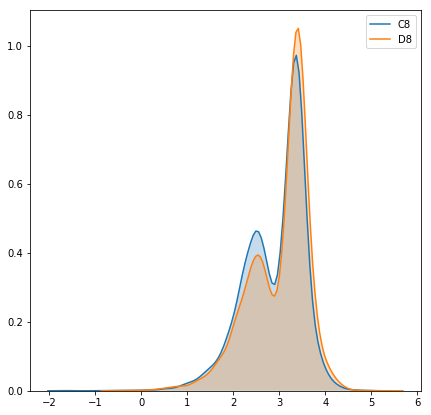

In [134]:
fig, ax = plt.subplots(figsize=(7, 7))

for well in wellsIwant:
    
    idx = ids['well'] == well
    
    #gotta get values, which is an array, hence the [0], to get the actual string inside the array
    #because fcsparser only takes string input, can't deal with dataframe slices or arrays
    path = ids.loc[idx, 'file'].values[0]
    
    meta, data = fcsparser.parse(path, meta_data_only=False, reformat_meta=True)
    
    
    #THIS ISN'T FINAL, I WANT TO COLLECT THE VARIOUS DATAS TOGETHER IN SOME LIST OR SOMETHING
    #FOR NOW I'M JUST DOING THIS PLOTTING ALTOGETHER IN A LOOP TO GET PLOTS
    
    #some of the values are negative, get rid of that 
    for col in data.columns:
        data.loc[data[col] < 0, col] = np.nan
        
    sns.kdeplot(np.log10(data['mKate/APC-A']), shade=True, ax=ax)
    ax.legend(wellsIwant)

### plot all the control cells on the same plot

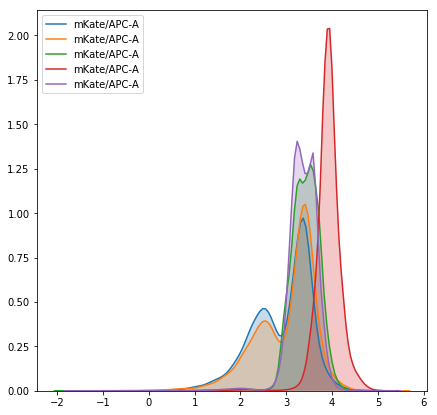

In [136]:
for ctrl in finalctrlfcs:

    meta, data = fcsparser.parse(ctrl, meta_data_only=False, reformat_meta=True)

    #some of the values are negative, get rid of that 
    for col in data.columns:
        data.loc[data[col] < 0, col] = np.nan

    sns.kdeplot(np.log10(data['mKate/APC-A']), shade=True, ax=ax)

fig

### eyeball gating to exclude negative cells

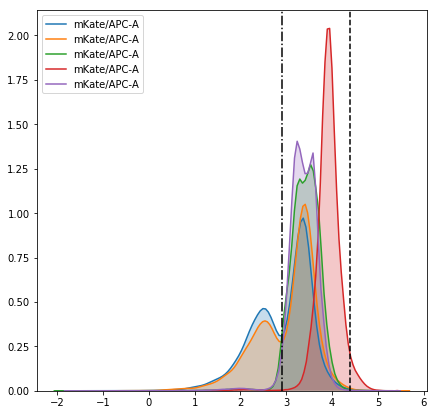

In [137]:
ax.axvline(np.log10(25000), color='k', linestyle='--')
ax.axvline(np.log10(800), color='k', linestyle='-.')

fig

### from adding veritcal lines to above plot, an mKate channel value of 25000 > value > 800 seems to be a good starting gate for syto for non blank cells, those cells are really bright in syto (prob because are log phase comp cells with more DNA)

### slice data

In [156]:
wellsIwant = ['C8', 'D8']

In [149]:
data.columns

Index(['HDR-T', 'FSC-A', 'SSC-A', 'CFP/VioBlue-A', 'PE-A', 'mKate/APC-A',
       'GFP/FITC-A'],
      dtype='object')

C:\Users\geeze\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


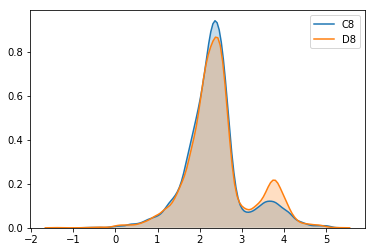

In [157]:
for well in wellsIwant:

    idx = ids['well'] == well

    #gotta get values, which is an array, hence the [0], to get the actual string inside the array
    #because fcsparser only takes string input, can't deal with dataframe slices or arrays
    path = ids.loc[idx, 'file'].values[0]

    meta, data = fcsparser.parse(path, meta_data_only=False, reformat_meta=True)

    #slice the syto gate
    cond1 = data['mKate/APC-A'] > 800
    cond2 = data['mKate/APC-A'] < 25000

    #get the yfp values within the syto gate
    gateslice = data.loc[(cond1 & cond2), 'GFP/FITC-A']

    sns.kdeplot(np.log10(gateslice), shade=True)
    #sns.kdeplot(np.log10(data['mKate/APC-A']), shade=True)
    
plt.legend(wellsIwant)

#show the YFP+ cells and the BFP+ cells on the YFP fluorescence axis to get idea where + and - YFP peaks are
sns.kdeplot(np.log10(), shade=True)

## Plots

### get something like what the MACSquant would show you

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set(xscale="log", yscale="log")

ax.set_xlim([10**-2, 10**6])
ax.set_ylim([1, 10**6])

ax.scatter(data['CFP/VioBlue-A'], data['SSC-A'], alpha=0.1, marker='o', s=1)

In [ ]:
#havent figured out how to get a color coded density plot yet without using seaborn kde plot which seems to hang
#and not generate anything

### Get histograms

In [ ]:
sns.kdeplot(np.log10(data['CFP/VioBlue-A']), shade=True)

#plt.xscale('log')

C:\Users\geeze\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


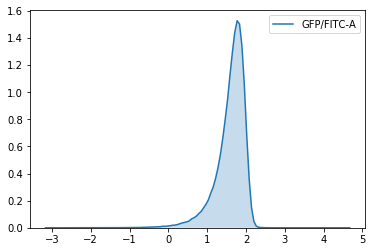

In [48]:
sns.kdeplot(np.log10(data['GFP/FITC-A']), shade=True)

#plt.xscale('log')